In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from difflib import get_close_matches

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from sklearn.metrics import f1_score

from xgboost import XGBClassifier, XGBRegressor, plot_importance

from sklearn.utils import shuffle

In [2]:
import pickle
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

### Functions and Classes

In [3]:
def window_groupby(df, grouper_key, freq, agg_grouping):
    """
    Group every x minutes
    
    INPUT:
    df - dataframe
    grouper_key - column (name) to be grouped on (must be datetime)
    freq - frequency of grouping
    agg_grouping - dictionary of aggregations 
    
    OUTPUT:
    grouped dataframe
    """
    df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
    
    if 'open_time' in agg_grouping.keys():
        df_temp.columns = [open_time_refine(col) for col in df_temp.columns]
    
    df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
    
    return df_temp

In [4]:
def open_time_refine(txt):
    """refine text"""
    if txt[0] != 'open_time':
        return txt[0]
    
    else:
        return txt[0] + '_' +txt[1]

In [5]:
def add_rolling_averges(df, list_to_add_unit_hour, index_unit):
    """
    INPUT:
    df - dataframe (assume the datafram is already sorted)
    list_to_add_unit_hour - list of rolling averages to add in the unit of hour, e.g.
                            list_to_add_unit_hour = [1, 2, 4] , will produce R.As of
                            1H, 2H, 4H (window calculated by dividing by the index_unit)
                            
    index_unit - unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)
    
    OUTPUT:
    dataframe with added rolling averages
    """
    df_temp = df
    
    rows = float(index_unit.replace('min',''))/60
    
    for ra in list_to_add_unit_hour:
        
        df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()
    
    return df_temp

In [6]:
def normalising_data(df, columns, base):
    """
    INPUT:
    df - dataframe to normalise
    columns - list of columns to be normalised (column/base)
    base - name of the normalised base (denominator)
    
    
    OUTPUT:
    df - normalised dataframe
    """
    assert base not in columns, "base should not be in the list of columns, as it will be dividing by 0"
    
    df_temp = df.copy(deep=True)
    
    for col in columns:
        df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[base]) - 1)
    
    return df_temp

In [7]:
df_ETHUSD_1min = pd.read_parquet('data/ETH-USDT.parquet')

#### Data Cleaning

In [8]:
"""Removing 0 volume"""
df_ETHUSD_1min = df_ETHUSD_1min[df_ETHUSD_1min['volume'] != 0].sort_index(ascending=True)

In [9]:
df_ETHUSD_1min['real_value'] = 1

In [10]:
df_ETHUSD_1min.isnull().any()

open                            False
high                            False
low                             False
close                           False
volume                          False
quote_asset_volume              False
number_of_trades                False
taker_buy_base_asset_volume     False
taker_buy_quote_asset_volume    False
real_value                      False
dtype: bool

In [11]:
min_df = df_ETHUSD_1min.iloc[0].name
max_df = df_ETHUSD_1min.iloc[-1].name
df_ETHUSD_1min_reindex = df_ETHUSD_1min.reindex(pd.date_range(start=min_df, end=max_df, freq='min')).copy(deep=True)#.fillna(-100)
df_ETHUSD_1min_reindex['high'] = df_ETHUSD_1min_reindex['high'].fillna(-999999)
df_ETHUSD_1min_reindex['low'] = df_ETHUSD_1min_reindex['low'].fillna(999999)
df_ETHUSD_1min_reindex = df_ETHUSD_1min_reindex.fillna(-100) # don't really need this step
df_ETHUSD_1min_reindex.index.name = 'open_time'

In [12]:
def get_max_min_time(df, freq):
    max_ids = df.reset_index().groupby(pd.Grouper(key ='open_time', freq=freq))['high'].idxmax()
    loc_max_ids = df.reset_index().loc[max_ids][['open_time']]
    loc_max_ids['max_{}_at_time'.format(freq)] = loc_max_ids['open_time']
    
    min_ids = df.reset_index().groupby(pd.Grouper(key ='open_time', freq=freq))['low'].idxmin()    
    loc_min_ids = df.reset_index().loc[min_ids][['open_time']]
    loc_min_ids['min_{}_at_time'.format(freq)] = loc_min_ids['open_time']

    df_max_at_time = loc_max_ids.groupby(pd.Grouper(key ='open_time', freq=freq))[['max_{}_at_time'.format(freq)]].first()
    df_min_at_time = loc_min_ids.groupby(pd.Grouper(key ='open_time', freq=freq))[['min_{}_at_time'.format(freq)]].first()

    df_max_min_time = df_max_at_time.merge(df_min_at_time, left_index=True, right_index=True, how='outer')
    
    return df_max_min_time

In [13]:
agg_grouping = {'open':'first',
                'high':'max',
                'low':'min',
                'close':'last',
                'volume':'sum',
                'quote_asset_volume':'sum',
                'open_time':['min','max','count']
               }

In [14]:
dict_df_by_minutes = {}

for g_minutes in [5, 10, 15, 20, 30, 60, 120, 180]:
#     print(g_minutes)
    freq = str(g_minutes) + 'min'
    df = window_groupby(df=df_ETHUSD_1min,
                           grouper_key='open_time',
                           freq=freq,
                           agg_grouping=agg_grouping
                             )
    df = df[df['open_time_count'] == g_minutes]
    
    df = df.merge(get_max_min_time(df=df_ETHUSD_1min_reindex, freq=freq), 
                  left_index = True,
                  right_index = True,
                  how='left')
    
    df['{}_high_after_low'.format(freq)] = df['max_{}_at_time'.format(freq)] > df['min_{}_at_time'.format(freq)]
    df['{}_percent_change'.format(freq)] = 100 * (df['high']/df['low'] - 1)
    dict_df_by_minutes[freq] = df


5
10
15
20
30
60
120
180


In [235]:
df_stats = []

for g_minutes in [5, 10, 15, 20, 30, 60, 120, 180]:
    freq = str(g_minutes) + 'min'
    print(freq, 
          dict_df_by_minutes[freq]['{}_high_after_low'.format(freq)].sum()/dict_df_by_minutes[freq]['{}_high_after_low'.format(freq)].count())
    
#     display(dict_df_by_minutes[freq].groupby('{}_high_after_low'.format(freq))[['{}_percent_change'.format(freq)]].describe())
    df_stats.append(dict_df_by_minutes[freq][(dict_df_by_minutes[freq]['{}_high_after_low'.format(freq)]==True) &
                                             (dict_df_by_minutes[freq]['{}_percent_change'.format(freq)]<= 6) ][['{}_percent_change'.format(freq)]].describe().T)

df_stats = pd.concat(df_stats)

5min 0.46457467520035817
10min 0.48948936398860876
15min 0.49093586003197515
20min 0.49330441000036357
30min 0.49081273380767254
60min 0.49402242518749534
120min 0.4971119945990548
180min 0.49903813511372636


In [236]:
df_stats['frequency'] = [int(d.split('min')[0]) for d in df_stats.index]

In [237]:
df_stats['relational_freq'] = 180/df_stats['frequency']

In [238]:
df_stats['estimated_return'] = df_stats['relational_freq']*df_stats['50%']

In [239]:
for fee in [0.2, 0.3, 0.4, 0.5]:
#     df_stats['0.{}%_fee'.format(fee)] = fee
    df_stats['fee_{}%'.format(fee)] = df_stats['relational_freq']* ( df_stats['50%'] - fee)

In [240]:
df_stats

,count,mean,std,min,25%,50%,75%,max,frequency,relational_freq,estimated_return,fee_0.2%,fee_0.3%,fee_0.4%,fee_0.5%
5min_percent_change,157661.0,0.392369,0.384283,0.002408,0.176775,0.281346,0.467885,5.966640,5,36.0,10.128450,2.928450,-0.671550,-4.271550,-7.871550
10min_percent_change,81893.0,0.546996,0.499401,0.003386,0.255823,0.401604,0.657403,5.920720,10,18.0,7.228875,3.628875,1.828875,0.028875,-1.771125
15min_percent_change,54248.0,0.669075,0.581419,0.006866,0.318503,0.496602,0.807756,5.962920,15,12.0,5.959225,3.559225,2.359225,1.159225,-0.040775
20min_percent_change,40585.0,0.770201,0.649730,0.016236,0.368965,0.576913,0.934494,5.990350,20,9.0,5.192220,3.392220,2.492220,1.592220,0.692220
30min_percent_change,26639.0,0.938777,0.746233,0.061178,0.459540,0.718939,1.150775,5.975378,30,6.0,4.313636,3.113636,2.513636,1.913636,1.313636
60min_percent_change,13156.0,1.309967,0.939537,0.094414,0.664318,1.031131,1.642221,5.986309,60,3.0,3.093392,2.493392,2.193392,1.893392,1.593392
120min_percent_change,6430.0,1.788777,1.113442,0.232041,0.973293,1.483756,2.310610,5.999434,120,1.5,2.225634,1.925634,1.775634,1.625634,1.475634
180min_percent_change,4176.0,2.116611,1.195831,0.252211,1.202384,1.838750,2.805597,5.981576,180,1.0,1.838750,1.638750,1.538750,1.438750,1.338750


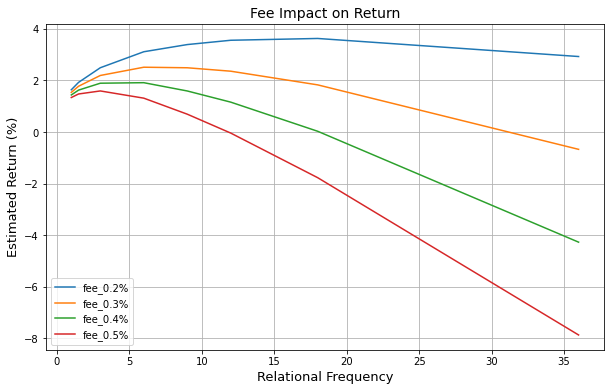

In [243]:
# plt.subplots(figsize =(8,4))
df_stats.set_index('relational_freq')[['fee_0.2%','fee_0.3%','fee_0.4%','fee_0.5%']].plot(figsize=(10,6))
plt.title('Fee Impact on Return', fontsize=14)
plt.ylabel('Estimated Return (%)', fontsize=13)
plt.xlabel('Relational Frequency', fontsize=13)
plt.grid()
plt.show()

In [22]:
df_15min = window_groupby(df=df_ETHUSD_1min,
                       grouper_key='open_time',
                       freq='15min',
                       agg_grouping=agg_grouping
                         )

In [23]:
df_15min['high_low_dif'] = 100*(df_15min['high'] - df_15min['low'])/df_15min['low']

In [24]:
df_15min[df_15min['high_low_dif'] <= 10][['high_low_dif']].describe().T

,count,mean,std,min,25%,50%,75%,max
high_low_dif,117466.0,0.710512,0.676803,0.0,0.324162,0.51434,0.851519,9.796008


### ML Training

##### Data Preparation

To train the regression model, the data must be normalised
Rather than normalising by 1 value, due to the range of max and min values, it would be more appropirate to normalise based on a "local" value (i.e. rolling average). Therefore, the percentage change relating to the rolling average would be a feature to be considered.

Here, 1, 2 and 4 Hours rolling average as well as the 15minutes one already present

To normalise, the 1H rolling average is used, this is picked as it smooths out the data but still retain some of the detail regarding the local trend.

In [25]:
df_prepare = add_rolling_averges(df_15min, [1,2,4], '15min').dropna(axis=0).copy(deep=True)
df_prepare['y_avg'] = df_prepare['avg'].shift(-1)
df_prepare['y_low'] = 100 * ((df_prepare['low'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_high'] = 100 * ((df_prepare['high'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_avg'] = 100 * ((df_prepare['avg'].shift(-1) - df_prepare['avg'])/df_prepare['avg'])
df_prepare = df_prepare[df_prepare['open_time_count'] == 15]

##### Data Normalisation

In [26]:
base = 'ra_1H'
columns_to_norm = [d for d in ['open','high','low','close','avg','ra_1H','ra_2H','ra_4H'] if d != base]
y_columns = ['y_avg','y_low','y_high']

In [27]:
df_normalised = normalising_data(df_prepare, columns=columns_to_norm, base=base)

In [28]:
## preparing dataframe for training
df_input = df_normalised[columns_to_norm + y_columns].copy(deep=True)

In [29]:
df_input = df_input[:-1]

In [30]:
df_input_set_aside = df_input[-17000:].copy(deep=True)

In [31]:
df_input_traintest = df_input[:-17000].copy(deep=True)

In [32]:
df_input_traintest = shuffle(df_input_traintest)

##### Model Training

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_input_traintest[columns_to_norm].values, 
                                                    df_input_traintest[['y_avg','y_low','y_high']].values ,
                                                    train_size=0.70,
                                                    random_state=42)

In [48]:
y_train_avg = np.copy(y_train[:,0])
y_train_low = np.copy(y_train[:,1])
y_train_high = np.copy(y_train[:,2])

y_test_avg = np.copy(y_test[:,0])
y_test_low = np.copy(y_test[:,1])
y_test_high = np.copy(y_test[:,2])

In [49]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [50]:
param_grid_xgboost = {
    'multi_clf__max_depth': [10, 50],
    'multi_clf__learning_rate': [0.01, 0.1, 0.5],
    'multi_clf__n_estimators' : [20, 100, 300],
    'multi_clf__gamma' : [0, 100, 1000],
    'multi_clf__colsample_bytree' : [0.2, 0.5, 1],
    'multi_clf__reg_alpha' : [1e-5, 1, 100]
}

In [51]:
pipeline_xgb_avg_rel = Pipeline([ ('multi_clf', XGBRegressor(nthread = -1, subsample=0.75)) ])
pipeline_xgb_low = Pipeline([ ('multi_clf', XGBRegressor(nthread = -1, subsample=0.75)) ])
pipeline_xgb_high = Pipeline([ ('multi_clf', XGBRegressor(nthread = -1, subsample=0.75)) ])

In [249]:
regres_xgb_avg_rel = XGBRegressor(nthread = -1, 
                                 subsample= 0.75,
                                 colsample_bytree= 1,
                                 gamma= 0,
                                 learning_rate= 0.01,
                                 max_depth= 10,
                                 n_estimators= 300,
                                 reg_alpha= 1e-05,
                                 eval_set=[(X_train, y_train), (X_test, y_test)])
regres_xgb_low = XGBRegressor(nthread = -1, 
                                 subsample= 0.75,
                                 colsample_bytree= 1,
                                 gamma= 0,
                                 learning_rate= 0.01,
                                 max_depth= 10,
                                 n_estimators= 300,
                                 reg_alpha= 1e-05,
                                 eval_set=[(X_train, y_train), (X_test, y_test)])
regres_xgb_high = XGBRegressor(nthread = -1, 
                                 subsample= 0.75,
                                 colsample_bytree= 1,
                                 gamma= 0,
                                 learning_rate= 0.01,
                                 max_depth= 10,
                                 n_estimators= 300,
                                 reg_alpha= 1e-05,
                                 eval_set=[(X_train, y_train), (X_test, y_test)])

In [53]:
"""Uncomment for GridSearchCV --- very long, 15 hours in total to run! """
# search_xgb_avg = GridSearchCV(pipeline_xgb_avg_rel, param_grid_xgboost, n_jobs=-1)
# search_xgb_avg.fit(X_train, y_train_avg)

# search_xgb_low = GridSearchCV(pipeline_xgb_low, param_grid_xgboost, n_jobs=-1)
# search_xgb_low.fit(X_train, y_train_low)

# search_xgb_high = GridSearchCV(pipeline_xgb_high, param_grid_xgboost, n_jobs=-1)
# search_xgb_high.fit(X_train, y_train_high)

GridSearchCV(estimator=Pipeline(steps=[('multi_clf',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     min_child_weight=None,
                                                   

In [262]:
# final_param_grid_xgboost = {
#     'multi_clf__max_depth': [10],
#     'multi_clf__learning_rate': [0.01],
#     'multi_clf__n_estimators' : [300],
#     'multi_clf__gamma' : [0],
#     'multi_clf__colsample_bytree' : [1],
#     'multi_clf__reg_alpha' : [1e-5]
# }

In [67]:
xgb_y_pred_avg_decision = search_xgb_avg.predict(X_test)

In [250]:
regres_xgb_avg_rel.fit(X_train, y_train_avg)
regres_xgb_low.fit(X_train, y_train_low)
regres_xgb_high.fit(X_train, y_train_high)

[23:46:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:46:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:46:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_set=[(array([[ 0.0639704 ,  0.2438406 ,  0.03326461, ...,  0.1430343 ,
        -0.13026951, -0.14193647],
       [-1.29663218, -0.99403766, -3.13896032, ..., -2.21714921,
         0.28106868,  0.02271783],
       [-0.14581285, -0.02281951, -0.31683673, ..., -0.18404853,
         0.09910945,  0.13910838],
       ...,
       [-...
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8, nthread=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=1e-05, reg_lambda=1,
             scale_pos_weight=1, subsample=0.75, tree_method='exact',
             validate_parameters=1, verbosity=None)

### valuation set

In [246]:
valuation_set = np.copy(df_input_set_aside[['open','high','low','close','avg','ra_2H','ra_4H']].values)

In [251]:
unseen_avg = np.copy(df_input_set_aside[['y_avg']].values)
unseen_low = np.copy(df_input_set_aside[['y_low']].values)
unseen_high = np.copy(df_input_set_aside[['y_high']].values)

In [292]:
def dumb_prediction():
    dumb_low = round(r2_score(df_input_set_aside['low'].values[1:], df_input_set_aside['low'].shift(1).values[1:]), 4)
    dumb_high = round(r2_score(df_input_set_aside['high'].values[1:], df_input_set_aside['high'].shift(1).values[1:]), 4)
    
    model_low = round( r2_score(unseen_low, regres_xgb_low.predict(valuation_set)), 4)
    model_high = round(r2_score(unseen_high, regres_xgb_high.predict(valuation_set)), 4)
    
    return """r2_score for
    dumb_low: {dumb_low}   vs model_low: {model_low}
    dumb_high: {dumb_high}  vs  model_high: {model_high}""".format(dumb_low=dumb_low, dumb_high=dumb_high, model_low=model_low, model_high=model_high)

In [293]:
print(dumb_prediction())

r2_score for
    dumb_low: 0.2063   vs model_low: 0.3376
    dumb_high: 0.3072  vs  model_high: 0.3094


Good improvement for low, but small improvement for high